## Descarga de información geoespacial 

In [ ]:
import ee

try:
    ee.Initialize()
    print("Google Earth Engine ha sido inicializado correctamente.")
except ee.EEException:
    print("Google Earth Engine no ha sido autenticado, por favor corre el comando 'earthengine authenticate' en tu terminal.")


In [ ]:
import ee

# Inicializa la API de Earth Engine
ee.Initialize()

# Carga el asset de las provincias del Perú
provincias = ee.FeatureCollection('projects/ee-mariocaceresreyna25/assets/PROVINCIAS_PERU')

# Filtra para obtener la provincia de Chumbivilcas
chumbivilcas = provincias.filter(ee.Filter.eq('PROVINCIA', 'CHUMBIVILCAS'))

# Carga el Modelo Digital de Elevación, por ejemplo, SRTM
dem = ee.Image('USGS/SRTMGL1_003')

# Recorta el DEM usando la provincia de Chumbivilcas como región de interés
dem_chumbivilcas = dem.clip(chumbivilcas)

# Define los parámetros para la exportación al Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': dem_chumbivilcas,
    'description': 'DEM_Chumbivilcas',
    'folder': 'GEE_Downloads',
    'fileNamePrefix': 'DEM_Chumbivilcas',
    'scale': 30,  # Puedes ajustar este valor según la resolución deseada
    'region': chumbivilcas.geometry(),
    'fileFormat': 'GeoTIFF'
})

# Inicia la tarea de exportación
task.start()

print("Exportación iniciada, revisa el progreso en Google Earth Engine Code Editor o en tu Google Drive.")


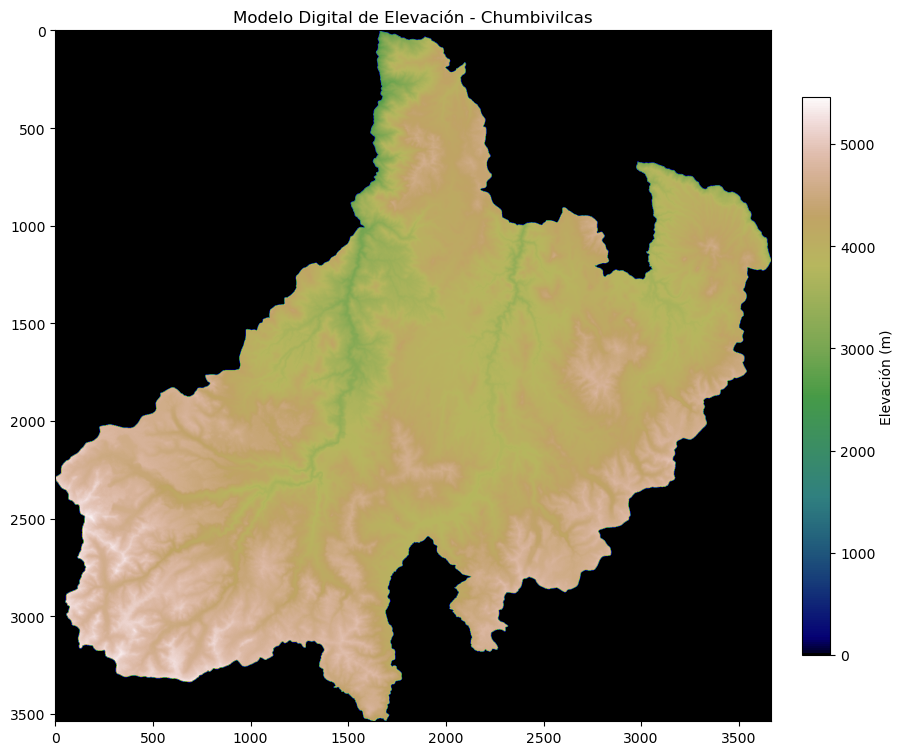

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Ruta al archivo DEM GeoTIFF
dem_path = 'E:/Talleres/Rutas_optimas/Insumos/DEM_Chumbivilcas.tif'

# Cargar el DEM con Rasterio
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Lee la primera banda

# Definir la paleta de colores para la visualización
# Esta es una paleta que va desde el verde (bajas altitudes) hasta el blanco (altas altitudes)
palette = plt.cm.gist_earth

# Visualizar el DEM con la paleta de colores
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(dem, cmap=palette)
ax.set_title('Modelo Digital de Elevación - Chumbivilcas')
fig.colorbar(cax, ax=ax, fraction=0.036, pad=0.04, label='Elevación (m)')
plt.show()


In [8]:
import geopandas as gpd

# Cargar el shapefile de puntos de interés
puntos_path = 'E:/CAPAS/Cap_Distrito/Cap_Distrito.shp'
puntos = gpd.read_file(puntos_path)

# Cargar el shapefile de la provincia de Chumbivilcas
provincia_path = 'E:/CAPAS/limite provincias/PROVINCIAS.shp'
provincias = gpd.read_file(provincia_path)

# Filtrar la provincia de Chumbivilcas
chumbivilcas = provincias[provincias['PROVINCIA'] == 'CHUMBIVILCAS']

# Realizar la selección espacial - encontrar puntos dentro de Chumbivilcas
puntos_chumbivilcas = gpd.sjoin(puntos, chumbivilcas, how="inner", op='intersects')

# puntos_chumbivilcas ahora contiene solo los puntos que están dentro de la provincia de Chumbivilcas
print(puntos_chumbivilcas)


    COD_IGN RASGO_PRIN CATEGORIA       NOMBRE     DISTRITO DEPARTA         X  \
548   CO220    Capital    PUEBLO  SANTO TOMAS  SANTO TOMAS   CUSCO -72.08256   
549   CO220    Capital    PUEBLO   CAPACMARCA   CAPACMARCA   CUSCO -71.99945   
550   CO220    Capital    PUEBLO      CHAMACA      CHAMACA   CUSCO -71.85245   
551   CO220    Capital    PUEBLO  COLQUEMARCA  COLQUEMARCA   CUSCO -72.04049   
552   CO220    Capital    PUEBLO     LIVITACA     LIVITACA   CUSCO -71.68928   
553   CO220    Capital    PUEBLO       LLUSCO       LLUSCO   CUSCO -72.11383   
554   CO220    Capital    PUEBLO      QUIÑOTA      QUIÑOTA   CUSCO -72.13630   
604   CO220    Capital    PUEBLO      VELILLE      VELILLE   CUSCO -71.88525   

            Y                     geometry  index_right IDDPTO DEPARTAMEN  \
548 -14.44910  POINT (-72.08256 -14.44910)           73     08      CUSCO   
549 -14.00880  POINT (-71.99945 -14.00880)           73     08      CUSCO   
550 -14.30214  POINT (-71.85245 -14.30214)      

c:\Users\USUARIO\miniconda3\envs\qgz\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


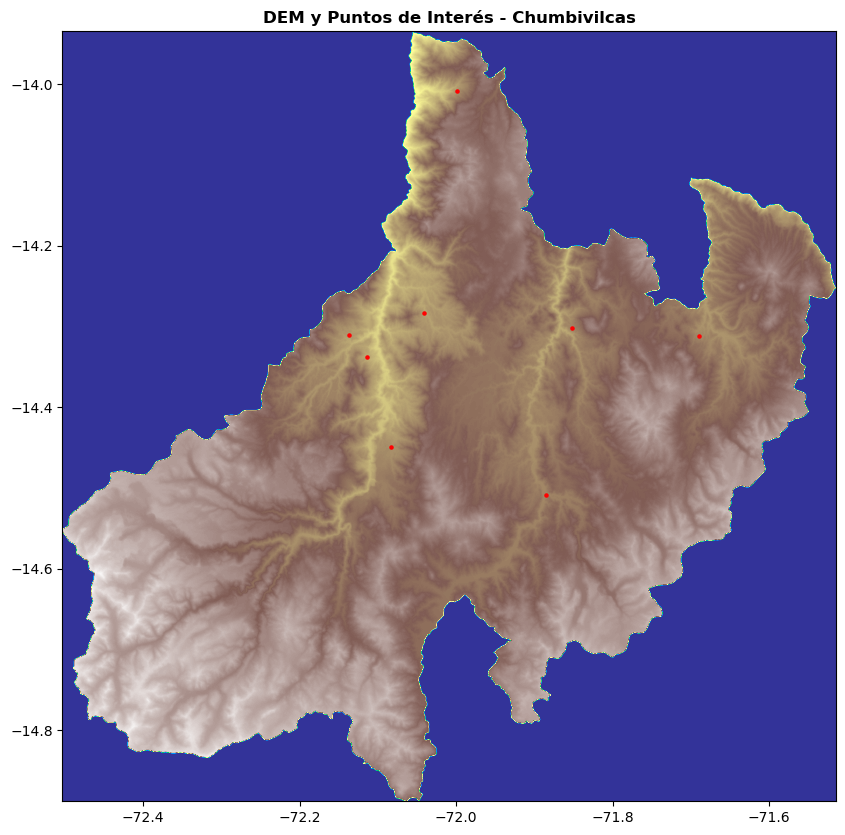

In [9]:
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

# Ruta al archivo DEM
dem_path = 'E:\\Talleres\\Rutas_optimas\\Insumos\\DEM_Chumbivilcas.tif'

# Cargar el DEM con Rasterio
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Lee la primera banda
    affine = src.transform

# Suponiendo que `puntos_chumbivilcas` es tu GeoDataFrame de puntos seleccionados
# Si no lo tienes cargado en este momento, cárgalo aquí con gpd.read_file()

# Visualizar el DEM
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(dem, ax=ax, transform=affine, cmap='terrain', title='DEM y Puntos de Interés - Chumbivilcas')

# Visualizar los puntos sobre el DEM
# Asegúrate de que los puntos están en las mismas coordenadas que el DEM
puntos_chumbivilcas.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()


In [10]:
from scipy.spatial import KDTree
import numpy as np

# Extrae las coordenadas de los puntos_chumbivilcas
coords = np.array(list(zip(puntos_chumbivilcas.geometry.x, puntos_chumbivilcas.geometry.y)))

# Construye el árbol KD para consultas eficientes de los puntos_chumbivilcas más cercanos
tree = KDTree(coords)

# Encuentra los puntos_chumbivilcas más cercanos para cada punto (excluyendo el propio punto)
distancias, indices = tree.query(coords, k=2)  # k=2 devuelve el punto más cercano y el propio punto

# Extrae los índices de los pares más cercanos (excluyendo el propio punto)
indices_pares = indices[:, 1]


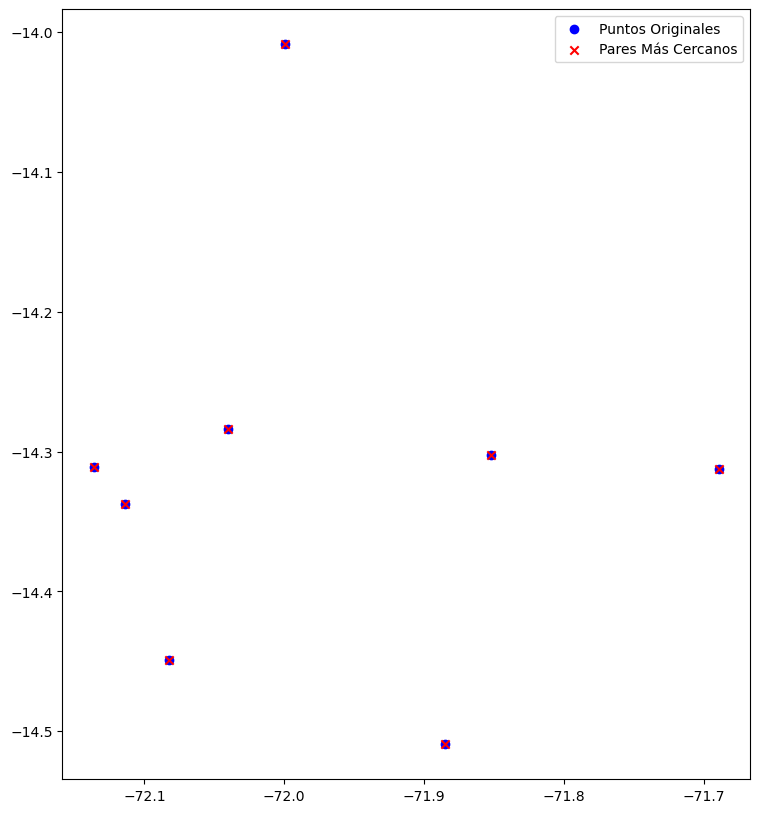

In [13]:
# Utiliza los índices de los pares más cercanos para crear un nuevo GeoDataFrame
# que contenga solo esos pares de puntos más cercanos.

import geopandas as gpd
import pandas as pd

# Inicializa una lista para almacenar las geometrías de los pares más cercanos
geometrias_pares_cercanos = []

# Itera sobre el array de índices para recoger los pares de puntos más cercanos
for i, indice in enumerate(indices_pares):
    punto_origen = puntos_chumbivilcas.iloc[i].geometry
    punto_destino = puntos_chumbivilcas.iloc[indice].geometry
    geometrias_pares_cercanos.append(punto_origen)
    geometrias_pares_cercanos.append(punto_destino)

# Crea un GeoDataFrame a partir de los pares más cercanos
gdf_pares_cercanos = gpd.GeoDataFrame(geometry=geometrias_pares_cercanos, columns=['geometry'])

# Ahora, gdf_pares_cercanos contiene los puntos de los pares más cercanos duplicados,
# para visualizarlos correctamente o trabajar con ellos, puedes querer eliminar duplicados.

# Eliminar duplicados basados en la geometría
gdf_pares_cercanos = gdf_pares_cercanos.drop_duplicates('geometry')

# Visualizar los pares más cercanos
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
puntos_chumbivilcas.plot(ax=ax, marker='o', color='blue', label='Puntos Originales')
gdf_pares_cercanos.plot(ax=ax, marker='x', color='red', label='Pares Más Cercanos')

plt.legend()
plt.show()


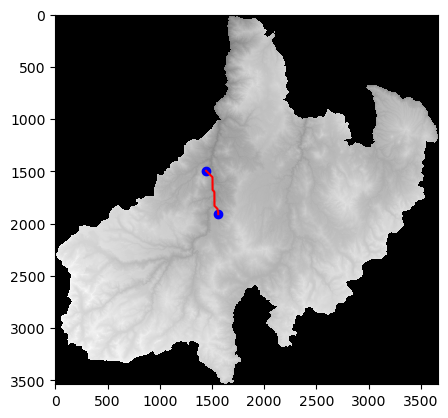

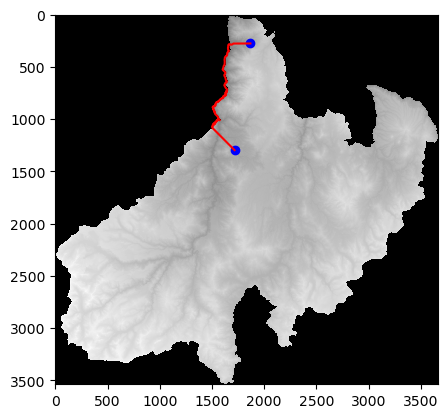

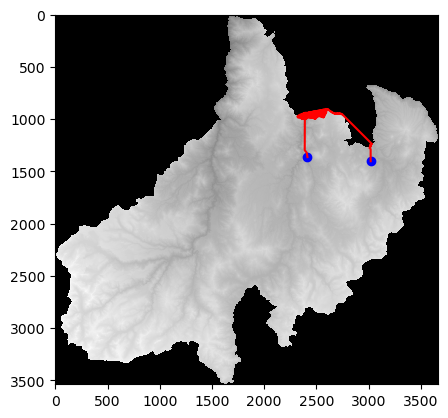

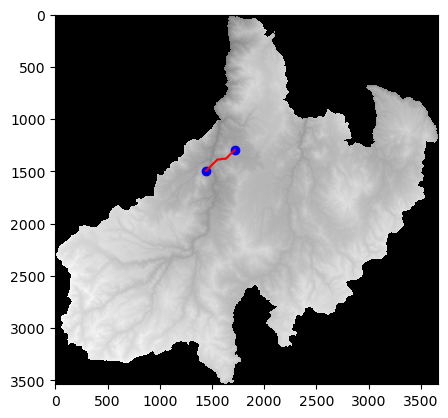

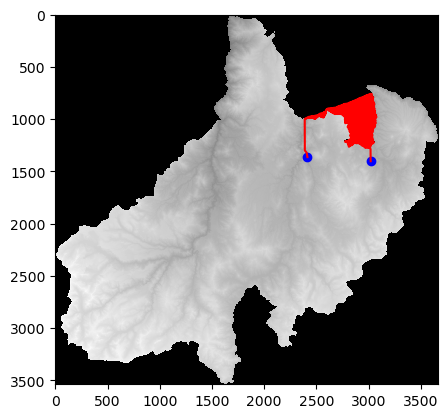

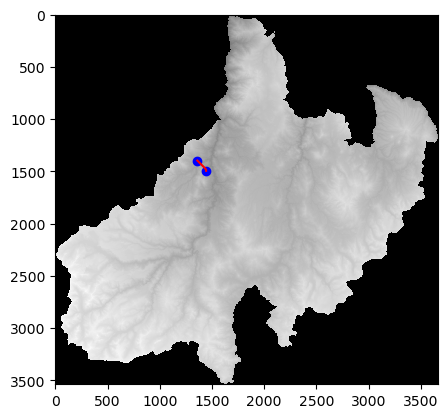

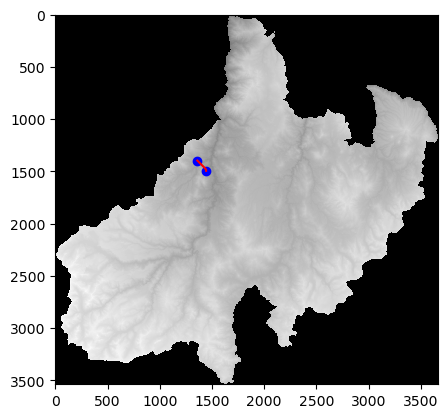

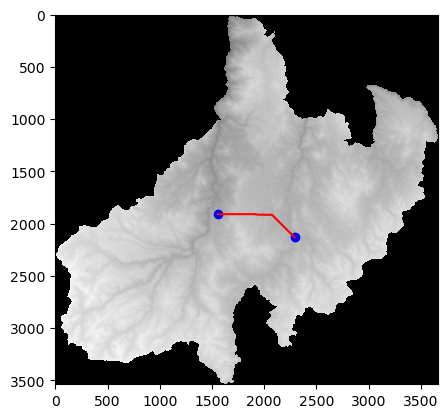

In [15]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from skimage.graph import route_through_array
import numpy as np
import matplotlib.pyplot as plt

# Cargar el DEM
dem_path = 'E:/Talleres/Rutas_optimas/Insumos/DEM_Chumbivilcas.tif'
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Asume que el DEM está en la primera banda
    transform = src.transform

# Función para convertir coordenadas geográficas a índices de matriz
def coords_to_indices(coords, transform):
    col, row = ~transform * coords
    return int(row), int(col)

# Suponiendo que `indices_pares` es tu array de índices de pares más cercanos
# Y que `puntos_chumbivilcas` es tu GeoDataFrame con los puntos

for i, indice in enumerate(indices_pares):
    punto_inicio = puntos_chumbivilcas.geometry.iloc[i]
    punto_fin = puntos_chumbivilcas.geometry.iloc[indice]

    # Convertir coordenadas a índices de matriz
    inicio_idx = coords_to_indices((punto_inicio.x, punto_inicio.y), transform)
    fin_idx = coords_to_indices((punto_fin.x, punto_fin.y), transform)

    # Calcular la ruta óptima
    indices, weight = route_through_array(dem, start=inicio_idx, end=fin_idx, fully_connected=True)
    ruta = np.array(indices).T
    
    # Visualización de la ruta sobre el DEM
    fig, ax = plt.subplots()
    ax.imshow(dem, cmap='gray', interpolation='nearest')
    ax.plot(ruta[1], ruta[0], color='red')  # Ruta óptima
    ax.scatter([inicio_idx[1], fin_idx[1]], [inicio_idx[0], fin_idx[0]], color='blue')  # Puntos de inicio y fin
    plt.show()

    # Aquí podrías añadir código para exportar la ruta y el costo a un shapefile o DataFrame
    # Nota: Este es un ejemplo para visualizar la ruta del primer par. Puedes adaptarlo para procesar todos los pares.


In [16]:
from shapely.geometry import LineString

def indices_to_coords(indices, transform):
    coords = [transform * (col, row) for row, col in indices]
    return coords

# Inicializa listas para almacenar datos de las rutas
lineas = []
costos = []
ids_inicio = []
ids_fin = []

# Procesa cada par de puntos para convertir las rutas de índices a LineStrings
for i, indice in enumerate(indices_pares):
    punto_inicio = puntos_chumbivilcas.geometry.iloc[i]
    punto_fin = puntos_chumbivilcas.geometry.iloc[indice]
    
    inicio_idx = coords_to_indices((punto_inicio.x, punto_inicio.y), transform)
    fin_idx = coords_to_indices((punto_fin.x, punto_fin.y), transform)
    
    indices_ruta, weight = route_through_array(dem, start=inicio_idx, end=fin_idx, fully_connected=True)
    coords_ruta = indices_to_coords(indices_ruta, transform)
    
    lineas.append(LineString(coords_ruta))
    costos.append(weight)
    ids_inicio.append(i)  # Suponiendo que i puede servir como identificador
    ids_fin.append(indice)  # O ajusta según tus identificadores reales


In [17]:
# Crea el GeoDataFrame
gdf_rutas = gpd.GeoDataFrame({
    'id_inicio': ids_inicio,
    'id_fin': ids_fin,
    'costo': costos,
    'geometry': lineas
}, crs=src.crs)  # Asegúrate de usar el mismo CRS que el DEM

# Exporta a shapefile
gdf_rutas.to_file('E:/Talleres/Rutas_optimas/Insumos/Rutas_Optimas.shp')
